##setting up spark#####

In [ ]:
!apt-get install openjdk-8-jdk-headless

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openjdk-8-jdk-headless is already the newest version (8u312-b07-0ubuntu1~18.04).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.


In [ ]:
!wget https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz

--2022-05-10 15:47:31--  https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
Resolving archive.apache.org (archive.apache.org)... 138.201.131.134, 2a01:4f8:172:2ec5::2
Connecting to archive.apache.org (archive.apache.org)|138.201.131.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 272637746 (260M) [application/x-gzip]
Saving to: ‘spark-3.2.1-bin-hadoop2.7.tgz.1’

spark-3.2.1-bin-had 100%[===================>] 260.01M  19.0MB/s    in 13s     

2022-05-10 15:47:45 (19.4 MB/s) - ‘spark-3.2.1-bin-hadoop2.7.tgz.1’ saved [272637746/272637746]



In [ ]:
!tar xf /content/spark-3.2.1-bin-hadoop2.7.tgz

In [ ]:
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()
findspark.find()

'/content/spark-3.2.1-bin-hadoop2.7'

In [ ]:
import pyspark
import numpy as np
import pandas as pd

#####loading the dataset#######

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master('local[*]').appName('Customer_Segmants').getOrCreate()

# Read data from CSV file
#you can download it from here:   https://raw.githubusercontent.com/besherh/BigDataManagement/main/SparkCSV/CC_GENERAL.csv
customer_df=spark.read.csv('/combined-data.csv', sep=',', header=True, inferSchema=True, nullValue='NULL')

customer_df.show(5)


+------+-------------+---------+------------+----------------+----------+-----------+---------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|
+------+-------------+---------+------------+----------------+----------+-----------+---------+
|   812|         5648|        1|     android|              69|         8|       null|     null|
|  1658|         5649|        1|      iphone|              31|         5|       null|     null|
|  1589|         5650|        1|      iphone|              26|         2|       null|     null|
|  1863|         5651|        1|     android|              35|         4|       null|     null|
|   937|         5652|        1|     android|              39|         0|          1|      1.0|
+------+-------------+---------+------------+----------------+----------+-----------+---------+
only showing top 5 rows



In [ ]:
customer_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- userSessionId: integer (nullable = true)
 |-- teamLevel: integer (nullable = true)
 |-- platformType: string (nullable = true)
 |-- count_gameclicks: integer (nullable = true)
 |-- count_hits: integer (nullable = true)
 |-- count_buyId: integer (nullable = true)
 |-- avg_price: double (nullable = true)



In [ ]:
customer_df.count()

4619

In [ ]:
from pyspark.sql.functions import col,isnan, when, count

In [ ]:
customer_df.na.drop().count()


1411

In [ ]:
customer_df.na.drop(how="any", thresh=2).show()

+------+-------------+---------+------------+----------------+----------+-----------+---------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|
+------+-------------+---------+------------+----------------+----------+-----------+---------+
|   812|         5648|        1|     android|              69|         8|       null|     null|
|  1658|         5649|        1|      iphone|              31|         5|       null|     null|
|  1589|         5650|        1|      iphone|              26|         2|       null|     null|
|  1863|         5651|        1|     android|              35|         4|       null|     null|
|   937|         5652|        1|     android|              39|         0|          1|      1.0|
|   342|         5653|        1|     android|              36|         5|       null|     null|
|   849|         5654|        1|      iphone|              40|         5|       null|     null|
|  1277|         5655|        1|     win

In [ ]:
from pyspark.ml.feature import Imputer

imputer = Imputer(
    inputCols=['count_buyId', 'avg_price'], 
    outputCols=["{}_imputed".format(c) for c in ['count_buyId', 'avg_price']]
    ).setStrategy("mean")

In [ ]:
 #Add imputation cols to customer_df
customer_df2 = imputer.fit(customer_df).transform(customer_df)

In [ ]:
customer_df2.show()

+------+-------------+---------+------------+----------------+----------+-----------+---------+-------------------+-----------------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|count_buyId_imputed|avg_price_imputed|
+------+-------------+---------+------------+----------------+----------+-----------+---------+-------------------+-----------------+
|   812|         5648|        1|     android|              69|         8|       null|     null|                  1|7.214323175053155|
|  1658|         5649|        1|      iphone|              31|         5|       null|     null|                  1|7.214323175053155|
|  1589|         5650|        1|      iphone|              26|         2|       null|     null|                  1|7.214323175053155|
|  1863|         5651|        1|     android|              35|         4|       null|     null|                  1|7.214323175053155|
|   937|         5652|        1|     android|              39|

In [ ]:
customer_df2.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- userSessionId: integer (nullable = true)
 |-- teamLevel: integer (nullable = true)
 |-- platformType: string (nullable = true)
 |-- count_gameclicks: integer (nullable = true)
 |-- count_hits: integer (nullable = true)
 |-- count_buyId: integer (nullable = true)
 |-- avg_price: double (nullable = true)
 |-- count_buyId_imputed: integer (nullable = true)
 |-- avg_price_imputed: double (nullable = true)



In [ ]:
from pyspark.sql import functions as F
categories = customer_df2.select("platformType").distinct().rdd.flatMap(lambda x: x).collect()

exprs = [F.when(F.col("platformType") == category, 1).otherwise(0).alias(category)
         for category in categories]

customer_df3 = customer_df2.select( "count_hits" , "count_gameclicks" , "avg_price_imputed" ,  *exprs)

In [ ]:
customer_df3=customer_df2.select("count_gameclicks","count_hits","avg_price_imputed")

In [ ]:
customer_df3.show()

+----------------+----------+-----------------+
|count_gameclicks|count_hits|avg_price_imputed|
+----------------+----------+-----------------+
|              69|         8|7.214323175053155|
|              31|         5|7.214323175053155|
|              26|         2|7.214323175053155|
|              35|         4|7.214323175053155|
|              39|         0|              1.0|
|              36|         5|7.214323175053155|
|              40|         5|7.214323175053155|
|              46|         8|7.214323175053155|
|              68|         6|7.214323175053155|
|              76|         9|7.214323175053155|
|              69|         6|7.214323175053155|
|             129|         9|             10.0|
|              36|         6|7.214323175053155|
|             102|        14|              5.0|
|             102|         7|7.214323175053155|
|              63|         8|7.214323175053155|
|             141|        21|7.214323175053155|
|              39|         4|           

In [ ]:
from pyspark.ml.feature import VectorAssembler
customer_df3.columns
assemble=VectorAssembler(inputCols=[
 "count_gameclicks",
 "count_hits",
 "avg_price_imputed",
 ], outputCol='features')
assembled_data=assemble.transform(customer_df3)
assembled_data.show(10)

+----------------+----------+-----------------+--------------------+
|count_gameclicks|count_hits|avg_price_imputed|            features|
+----------------+----------+-----------------+--------------------+
|              69|         8|7.214323175053155|[69.0,8.0,7.21432...|
|              31|         5|7.214323175053155|[31.0,5.0,7.21432...|
|              26|         2|7.214323175053155|[26.0,2.0,7.21432...|
|              35|         4|7.214323175053155|[35.0,4.0,7.21432...|
|              39|         0|              1.0|      [39.0,0.0,1.0]|
|              36|         5|7.214323175053155|[36.0,5.0,7.21432...|
|              40|         5|7.214323175053155|[40.0,5.0,7.21432...|
|              46|         8|7.214323175053155|[46.0,8.0,7.21432...|
|              68|         6|7.214323175053155|[68.0,6.0,7.21432...|
|              76|         9|7.214323175053155|[76.0,9.0,7.21432...|
+----------------+----------+-----------------+--------------------+
only showing top 10 rows



In [ ]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.show(20)

+----------------+----------+-----------------+--------------------+--------------------+
|count_gameclicks|count_hits|avg_price_imputed|            features|        standardized|
+----------------+----------+-----------------+--------------------+--------------------+
|              69|         8|7.214323175053155|[69.0,8.0,7.21432...|[0.54380637390174...|
|              31|         5|7.214323175053155|[31.0,5.0,7.21432...|[0.24431880566599...|
|              26|         2|7.214323175053155|[26.0,2.0,7.21432...|[0.20491254668761...|
|              35|         4|7.214323175053155|[35.0,4.0,7.21432...|[0.27584381284870...|
|              39|         0|              1.0|      [39.0,0.0,1.0]|[0.30736882003141...|
|              36|         5|7.214323175053155|[36.0,5.0,7.21432...|[0.28372506464438...|
|              40|         5|7.214323175053155|[40.0,5.0,7.21432...|[0.31525007182709...|
|              46|         8|7.214323175053155|[46.0,8.0,7.21432...|[0.36253758260116...|
|         

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    score=evaluator.evaluate(output)
    silhouette_score.append(score)
    print("Silhouette Score:",score)

Silhouette Score: 0.7717722580877626
Silhouette Score: 0.7933619089102762
Silhouette Score: 0.4870761146688114
Silhouette Score: 0.7017393643601577
Silhouette Score: 0.6248471874990648
Silhouette Score: 0.5808421572430634
Silhouette Score: 0.5769132120355507
Silhouette Score: 0.5801681188109065


Text(0, 0.5, 'cost')

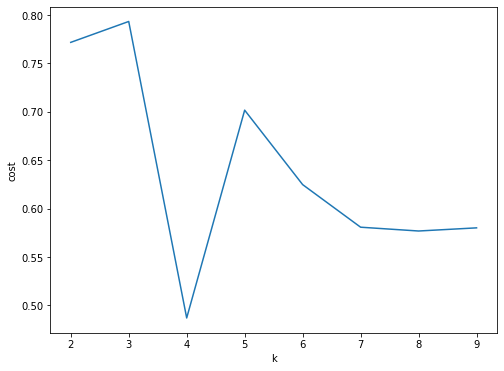

In [ ]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [ ]:
KMeans_=KMeans(featuresCol='features', k=3) 
KMeans_Model=KMeans_.fit(data_scale_output)
KMeans_Assignments=KMeans_Model.transform(data_scale_output)

In [ ]:
centers = KMeans_Model.clusterCenters()
centers

[array([92.8976378 , 10.35025794,  7.24156549]),
 array([613.20588235,  65.24117647,   6.94540614]),
 array([279.9229765 ,  30.46214099,   7.14302087])]

In [ ]:
KMeans_Assignments.show(1)


+----------------+----------+-----------------+--------------------+--------------------+----------+
|count_gameclicks|count_hits|avg_price_imputed|            features|        standardized|prediction|
+----------------+----------+-----------------+--------------------+--------------------+----------+
|              69|         8|7.214323175053155|[69.0,8.0,7.21432...|[0.54380637390174...|         0|
+----------------+----------+-----------------+--------------------+--------------------+----------+
only showing top 1 row



In [ ]:
from pyspark.ml.feature import PCA as PCAml
pca = PCAml(k=3, inputCol="features", outputCol="prediction")
pca_model = pca.fit(data_scale_output)
pca_transformed = pca_model.transform(data_scale_output)

In [ ]:
KMeans_Assignments.show(1)


+----------+----------------+-----------------+------+-------+-----+---+-------+--------------------+--------------------+----------+
|count_hits|count_gameclicks|avg_price_imputed|iphone|android|linux|mac|windows|            features|        standardized|prediction|
+----------+----------------+-----------------+------+-------+-----+---+-------+--------------------+--------------------+----------+
|         8|              69|7.214323175053155|     0|      1|    0|  0|      0|(8,[0,1,2,4],[69....|(8,[0,1,2,4],[0.5...|         3|
+----------+----------------+-----------------+------+-------+-----+---+-------+--------------------+--------------------+----------+
only showing top 1 row



In [ ]:
import numpy as np
x_pca = np.array(pca_transformed.rdd.map(lambda row: row.prediction).collect())

In [ ]:
cluster_assignment = np.array(KMeans_Assignments.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


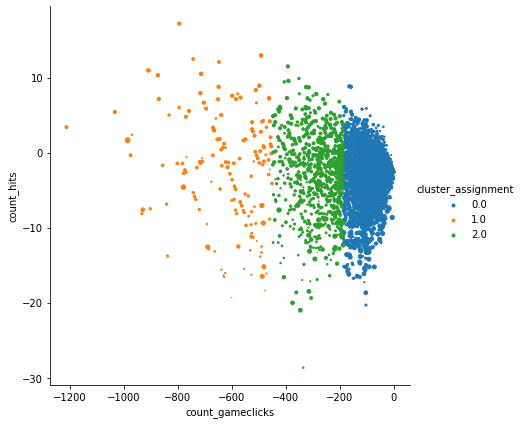

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

pca_data = np.hstack((x_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("count_gameclicks", "count_hits","avg_price_imputed","cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, 'count_gameclicks', 'count_hits','avg_price_imputed' ).add_legend()

plt.show()

###############decision tree###################